In [1]:
#import packages
import numpy as np
from numpy import loadtxt
import pylab as pl
from IPython import display
from RcTorch import *
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import time
import matplotlib.gridspec as gridspec

#this method will ensure that the notebook can use multiprocessing (train multiple 
#RC's in parallel) on jupyterhub or any other linux based system.
try:
    mp.set_start_method("spawn")
except:
    pass
torch.set_default_tensor_type(torch.FloatTensor)
%matplotlib inline
start_time = time.time()

In [2]:
# ! pip install rctorch==0.7163

In [3]:
lineW = 3
lineBoxW=2
plt.rcParams['text.usetex'] = True

### This notebook demonstrates how to use RcTorch to find optimal hyper-paramters for the differential equation $\dot y + q(t) y = f(t) $.

Simple population:  <font color='blue'>$\dot y + y =0$  </font>
* Analytical solution: <font color='green'>$y = y_0 e^{-t}$</font>

In [4]:
#define a reparameterization function, empirically we find that g= 1-e^(-t) works well)
def reparam(t, order = 1):
    
    exp_t = torch.exp(-t)
    derivatives_of_g = []
    
    g = 1 - exp_t
    g_dot = 1 - g
    return g, g_dot

In [5]:
def plot_predictions(RC, results, integrator_model, ax = None):
    """plots a RC prediction and integrator model prediction for comparison
    Parameters
    ----------
    RC: RcTorchPrivate.esn
        the RcTorch echostate network to evaluate. This model should already have been fit.
    results: dictionary
        the dictionary of results returned by the RC after fitting
    integrator model: function
        the model to be passed to odeint which is a gold standard integrator numerical method
        for solving ODE's written in Fortran. You may find the documentation here:
        https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html
    ax: matplotlib.axes._subplots.AxesSubplot
        If provided, the function will plot on this subplot axes
    """
    X = RC.X.cpu()
    if not ax:
        fig, ax = plt.subplots(1,1, figsize = (6,6))
    for i, y in enumerate(results["ys"]):
        y = y.cpu()
        if not i:
            labels = ["RC", "Integrator Solution"]
        else:
            labels = [None, None]
        ax.plot(X, y, color = "dodgerblue", label = labels[0], linewidth = lineW + 1, alpha = 0.9)

        #calculate the integrator prediction:
        int_sol = odeint(integrator_model, y0s[i], np.array(X.cpu().squeeze()))
        int_sol = torch.tensor(int_sol)
        
        #plot the integrator prediction
        ax.plot(X, int_sol, '--', color = "red", alpha = 0.9, label = labels[1],  linewidth = lineW)
    
    plt.ylabel(r'$y(t)$');
    ax.legend();
    ax.tick_params(labelbottom=False)
    plt.tight_layout()

def covert_ode_coefs(t, ode_coefs):
    """ converts coefficients from the string 't**n' or 't^n' where n is any float
    Parameters
    ----------
    t: torch.tensor
        input time tensor
    ode_coefs: list
        list of associated floats. List items can either be (int/floats) or ('t**n'/'t^n')
    Returns
    -------
    ode_coefs
    """
    type_t = type(t)
    for i, coef in enumerate(ode_coefs):
        if type(coef) == str:
            if coef[0] == "t" and (coef[1] == "*" or (coef[1] == "*" and coef[2] == "*")):
                pow_ = float(re.sub("[^0-9.-]+", "", coef))
                ode_coefs[i]  = t ** pow_
                print("alterning ode_coefs")
        elif type(coef) in [float, int, type_t]:
            pass
        else:
            assert False, "ode_coefs must be a list floats or strings of the form 't^pow', where pow is a real number."
    return ode_coefs
    

def plot_rmsr(RC, results, force, ax = None):
    """plots the residuals of a RC prediction directly from the loss function
    Parameters
    ----------
    RC: RcTorchPrivate.esn
        the RcTorch echostate network to evaluate. This model should already have been fit.
    results: dictionary
        the dictionary of results returned by the RC after fitting
    force: function
        the force function describing the force term in the population equation
    ax: matplotlib.axes._subplots.AxesSubplot
        If provided, the function will plot on this subplot axes
    """
    if not ax:
        fig, ax = plt.subplots(1,1, figsize = (10, 4))
    X = RC.X.cpu()
    ys, ydots = results["ys"], results["ydots"]
    
    residuals = []
    force_t = force(X)
    for i, y in enumerate(ys):
        ydot = ydots[i]
        y = y.cpu()
        ydot = ydot.cpu()
        
        ode_coefs = covert_ode_coefs(t = X, ode_coefs = RC.ode_coefs)
        
        resids = custom_loss(X, y, ydot, None, 
                             force_t = force_t, 
                             ode_coefs = RC.ode_coefs,
                             mean = False)
        if not i:
            resids_tensor = resids
            label = r'{Individual Trajectory RMSR}'
        else:
            resids_tensor = torch.cat((resids_tensor, resids), axis = 1)
            label = None
        resids_specific_rmsr = torch.sqrt(resids/1) 
            
        ax.plot(X, resids_specific_rmsr, color = "orangered", alpha = 0.4, label = label, linewidth = lineW-1)
        residuals.append(resids)
    
    mean_resid = torch.mean(resids_tensor, axis =1)
    rmsr = torch.sqrt(mean_resid)
    ax.plot(X, rmsr, 
               color = "blue", 
               alpha = 0.9, 
               label = r'{RMSR}',
               linewidth = lineW-0.5)

    ax.legend(prop={"size":16});
    
    ax.set_xlabel(r'$t$')
    ax.set_yscale("log")
    ax.set_ylabel(r'{RMSR}')

In [6]:
# common cv arguments:
cv_declaration_args = {"interactive" : True, 
                       "batch_size" : 8, #batch size is parallel
                       "cv_samples" : 2, #number of cv_samples, random start points
                       "initial_samples" : 50, #number of random samples before optimization starts
                       "validate_fraction" : 0.3, #validation prop of tr+val sets
                       "log_score" : True, #log-residuals
                       "random_seed" : 209, # random seed
                       "ODE_order" : 1, #order of eq
                       #see turbo ref:
                       "length_min" : 2 ** (-7),#2 **(-7), 
                       "success_tolerance" : 10}

## task 1: cross check burn in for all three experiments (burn in should be embedded into hps)


In [7]:
def driven_force(X, A = 1):
    """ a force function, specifically f(t) = sin(t)
    Parameters
    ----------
    X: torch.tensor
        the input time tensor
    
    Returns
    -------
    the force, a torch.tensor of equal dimension to the input time tensor.
    """
    return A*torch.sin(X)

def no_force(X):
    """ a force function (returns 0)
    
    Parameters
    ----------
    X: torch.tensor
        the input time tensor
    
    Returns
    -------
    the force, in this case 0.
    """
    return 0

lam =1
def custom_loss(X , y, ydot, out_weights, lam = lam, force_t = None, reg = False, 
               ode_coefs = None, init_conds = None, 
                enet_alpha = None, enet_strength =None, mean = True):
    """ The loss function of the ODE (in this case the population equation loss)
    Parameters
    ----------
    X: torch.tensor
        The input (in the case of ODEs this is time t)
    y: torch.tensor
        The response variable
    ydot: torch.tensor
        The time derivative of the response variable
    enet_strength: float
        the magnitude of the elastic net regularization parameter. In this case there is no e-net regularization
    enet_alpha: float
        the proportion of the loss that is L2 regularization (ridge). 1-alpha is the L1 proportion (lasso).
    ode_coefs: list
        this list represents the ODE coefficients. They can be numbers or t**n where n is some real number.
    force: function
        this function needs to take the input time tensor and return a new tensor f(t)
    reg: bool
        if applicable (not in the case below) this will toggle the elastic net regularization on and off
    reparam: function
        a reparameterization function which needs to take in the time tensor and return g and gdot, which 
        is the reparameterized time function that satisfies the initial conditions.
    init_conds: list
        the initial conditions of the ODE.
    mean: bool
        if true return the cost (0 dimensional float tensor) else return the residuals (1 dimensional tensor)
        
    Returns
    -------
    the residuals or the cost depending on the mean argument (see above)
    """
    #with paramization
    L =  ydot  + lam * y - force_t
    
#     if reg:
#         #assert False
#         weight_size_sq = torch.mean(torch.square(out_weights))
#         weight_size_L1 = torch.mean(torch.abs(out_weights))
#         L_reg = enet_strength*(enet_alpha * weight_size_sq + (1- enet_alpha) * weight_size_L1)
#         L = L + 0.1 * L_reg 
    
    L = torch.square(L)
    if mean:
        L = torch.mean(L)
    return L

In [8]:
#declare the initial conditions (each initial condition corresponds to a different curve)
y0s = np.arange(0.1, 2.1, 0.1)
len(y0s)

20

### Simple population

In [9]:
#declare the bounds dict. We search for the variables within the specified bounds.
# if a variable is declared as a float or integer like n_nodes or dt, these variables are fixed.
bounds_dict = {"connectivity" : (-2.2, -0.12), #log space
               "spectral_radius" : (1, 10), #lin space
               "n_nodes" : 250, 
               "regularization" : (-4, 4), #log space
               "leaking_rate" : (0, 1),    #linear space
               "dt" : -2.5, #log space
               "bias": (-0.75,0.75) #linear space
               }

#set up data
x0, xf = 0, 5
nsteps = int(abs(xf - x0)/(10**bounds_dict["dt"]))
xtrain = torch.linspace(x0, xf, nsteps, requires_grad=False).view(-1,1)
int(xtrain.shape[0] * 0.5)

790

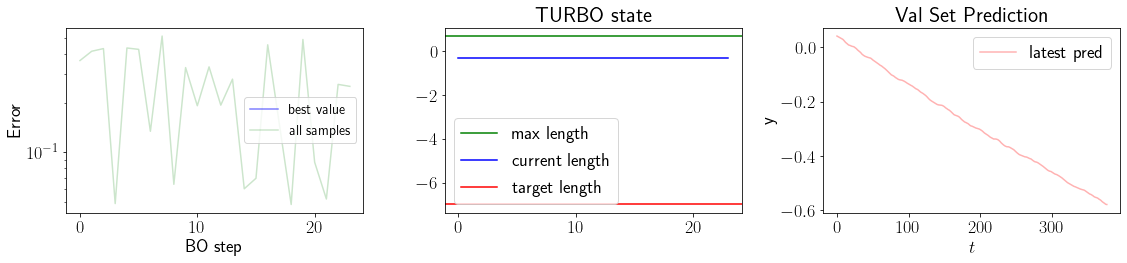

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 9, in <module>
  File "/usr/local/anaconda3/lib/python3.8/site-packages/RcTorch/esn_cv.py", line 1601, in optimize
    Y_batch = self.eval_objective( X_batch )
  File "/usr/local/anaconda3/lib/python3.8/site-packages/RcTorch/esn_cv.py", line 1318, in eval_objective
    results = Pool.map(execute_objective, data_args)
  File "/usr/local/anaconda3/lib/python3.8/multiprocessing/pool.py", line 364, in map
    return self._map_async(func, iterable, mapstar, chunksize).get()
  File "/usr/local/anaconda3/lib/python3.8/multiprocessing/pool.py", line 765, in get
    self.wait(timeout)
  File "/usr/local/anaconda3/lib/python3.8/multiprocessing/pool.py", line 762, in wait
    self._event.wait(timeout)
  File "/usr/local/anaconda3/lib/python3.8/threading.py", line 558, in wait
    signaled = self

TypeError: object of type 'NoneType' has no len()

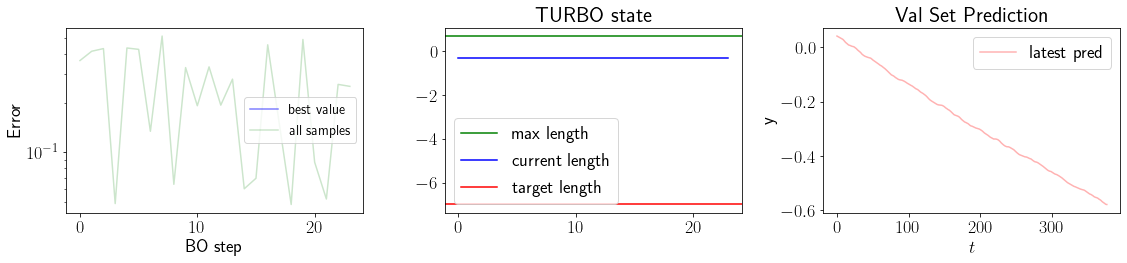

In [10]:
%%time
#declare the esn_cv optimizer: this class will run bayesian optimization to optimize the bounds dict.
#for more information see the github.
esn_cv = EchoStateNetworkCV(bounds = bounds_dict,
                            esn_burn_in = 500, #states to throw away before calculating output
                            subsequence_length = int(xtrain.shape[0] * 0.8), #combine len of tr + val sets
                            **cv_declaration_args
                            )
#optimize the network:
simple_pop_hps = esn_cv.optimize(x = xtrain,
                          reparam_f = reparam, 
                          ODE_criterion = custom_loss,
                          init_conditions = [y0s], 
                          force = no_force,
                          ode_coefs = [1, 1],
                          n_outputs = 1,
                          reg_type = "simple_pop")

In [ ]:
%%time
pop_RC = EchoStateNetwork(**simple_pop_hps,
                         random_state = 209, 
                         dtype = torch.float32)

train_args = {"X" : xtrain.view(-1,1),        
              "burn_in" : 500, 
              "ODE_order" : 1,   
              "force" : no_force, 
              "reparam_f" : reparam,
              "ode_coefs" : [1, 1]}


pop_results = pop_RC.fit(init_conditions = [y0s,1],
                        SOLVE = True,
                        train_score = True, 
                        ODE_criterion = custom_loss,
                        **train_args)

In [ ]:
def simple_pop(y, t, t_pow = 0, force_k = 0, k = 1):
    dydt = -k * y *t**t_pow + force_k*np.sin(t)
    return dydt

In [ ]:
#TODO: show results outside BO range

In [ ]:
# some particularly good runs:

# simple_pop_hps = {'dt': 0.0031622776601683794,
#  'n_nodes': 250,
#  'connectivity': 0.13615401772200952,
#  'spectral_radius': 4.1387834548950195,
#  'regularization': 0.00028325262824591835,
#  'leaking_rate': 0.2962796092033386,
#  'bias': -0.5639935731887817}

# opt_hps = {'dt': 0.0031622776601683794,
#  'n_nodes': 250,
#  'connectivity': 0.7170604557008349,
#  'spectral_radius': 1.5755887031555176,
#  'regularization': 0.00034441529823729916,
#  'leaking_rate': 0.9272222518920898,
#  'bias': 0.1780446171760559}

# opt_hps = {'dt': 0.0017782794100389228,
#  'n_nodes': 250,
#  'connectivity': 0.11197846061157432,
#  'spectral_radius': 1.7452095746994019,
#  'regularization': 0.00012929296298723957,
#  'leaking_rate': 0.7733328938484192,
#  'bias': 0.1652531623840332}

In [ ]:

fig = plt.figure(figsize = (9, 7)); gs1 = gridspec.GridSpec(3, 3);
ax = plt.subplot(gs1[:-1, :])

gts = plot_predictions(RC = pop_RC, 
                       results = pop_results, 
                       integrator_model = simple_pop, 
                       ax = ax)

ax = plt.subplot(gs1[-1, :])
plot_data = plot_rmsr(pop_RC, 
                      results = pop_results, 
                      force = no_force, 
                      ax = ax)

### Driven population:

In [ ]:
#declare the bounds dict. We search for the variables within the specified bounds.
# if a variable is declared as a float or integer like n_nodes or dt, these variables are fixed.
bounds_dict = {"connectivity" : (-2, -0.12), #log space
               "spectral_radius" : (1, 10), #lin space
               "n_nodes" : 400, 
               "regularization" : (-4, 4), #log space
               "leaking_rate" : (0, 1),    #linear space
               "dt" : -2.5, #log space
               "bias": (-0.75,0.75) #linear space
               }

In [ ]:
%%time
#declare the esn_cv optimizer: this class will run bayesian optimization to optimize the bounds dict.
#for more information see the github.
esn_cv = EchoStateNetworkCV(bounds = bounds_dict,
                            esn_burn_in = 500, #states to throw away before calculating output
                            subsequence_length = int(xtrain.shape[0] * 0.8), #combine len of tr + val sets
                            **cv_declaration_args
                            )
#optimize the network:
driven_pop_hps = esn_cv.optimize(x = xtrain,
                          reparam_f = reparam, 
                          ODE_criterion = custom_loss,
                          init_conditions = [y0s], 
                          force = driven_force,
                          ode_coefs = [1, 1],
                          n_outputs = 1,
                          reg_type = "driven_pop")

In [ ]:
y0s = np.arange(-10, 10.1, 1)
len(y0s)

In [ ]:
%%time
driven_RC = EchoStateNetwork(**driven_pop_hps,
                         random_state = 209, 
                         dtype = torch.float32)

train_args = {"X" : xtrain.view(-1,1),        
              "burn_in" : 500, 
              "ODE_order" : 1,   
              "force" : driven_force, 
              "reparam_f" : reparam,
              "ode_coefs" : [1, 1]}


driven_results = driven_RC.fit(init_conditions = [y0s,1],
                    SOLVE = True,
                    train_score = True, 
                    ODE_criterion = custom_loss,
                    **train_args)

In [ ]:
def driven_pop(y, t, t_pow = 0, force_k = 1, k = 1):
    dydt = -k * y *t**t_pow + force_k*np.sin(t)
    return dydt


In [ ]:
driven_pop_hps

In [ ]:
fig = plt.figure(figsize = (9, 7)); gs1 = gridspec.GridSpec(3, 3);
ax = plt.subplot(gs1[:-1, :])

gts = plot_predictions(RC = driven_RC, 
                       results = driven_results, 
                       integrator_model = driven_pop, 
                       ax = ax)

ax = plt.subplot(gs1[-1, :])
plot_data = plot_rmsr(driven_RC, 
                      results = driven_results, 
                      force = driven_force, 
                      ax = ax)

#### Driven t^2 Population:

In [ ]:
#declare the initial conditions (each initial condition corresponds to a different curve)
y0s = np.arange(-10, 10.1, 0.1)
len(y0s)

In [ ]:
np.log10(0.005)

In [ ]:
#declare the bounds dict. We search for the variables within the specified bounds.
# if a variable is declared as a float or integer like n_nodes or dt, these variables are fixed.

t2_hps =  {'n_nodes': 500,
           'connectivity': 0.09905712745750006,
           'spectral_radius': 1.8904799222946167,
           'regularization': 714.156090350679,
           'leaking_rate': 0.031645022332668304,
           'bias': -0.24167031049728394,
           'dt' : 0.005}

bounds_dict = {"connectivity" : (-1.1, -0.9), #log space
               "spectral_radius" : (1.8, 2.0), #lin space
               "n_nodes" : 500, 
               "regularization" : (2.5, 3.5), #log space
               "leaking_rate" : (0.02, .04),    #linear space
               "dt" : -2.3, #log space
               "bias": (0,1) #linear space
               }

In [ ]:
%%time
#declare the esn_cv optimizer: this class will run bayesian optimization to optimize the bounds dict.
#for more information see the github.
esn_cv = EchoStateNetworkCV(bounds = bounds_dict,
                            esn_burn_in = 1000, #states to throw away before calculating output
                            subsequence_length = int(xtrain.shape[0] * 0.8), #combine len of tr + val sets
                            **cv_declaration_args
                            )
#optimize the network:
t2_pop_hps = esn_cv.optimize(x = xtrain,
                          reparam_f = reparam, 
                          ODE_criterion = custom_loss,
                          init_conditions = [y0s], 
                          force = driven_force,
                          ode_coefs = ["t^2", 1],
                          n_outputs = 1,
                          reg_type = "driven_pop")

In [ ]:
#solution run:
# t2_hps =  {'n_nodes': 500,
#            'connectivity': 0.09905712745750006,
#            'spectral_radius': 1.8904799222946167,
#            'regularization': 714.156090350679,
#            'leaking_rate': 0.031645022332668304,
#            'bias': -0.24167031049728394,
#            'dt' : 0.005}

In [ ]:
def t2_pop(y, t, t_pow = 2, force_k = 1, k = 1):
    dydt = -k * y *t**t_pow + force_k*np.sin(t)
    return dydt

In [ ]:
%%time
t2_RC = EchoStateNetwork(**t2_pop_hps,
                         random_state = 209, 
                         dtype = torch.float32)

train_args = {"X" : xtrain.view(-1,1),        
              "burn_in" : 1000, 
              "ODE_order" : 1,   
              "force" : driven_force, 
              "reparam_f" : reparam,
              "ode_coefs" : ["t^2", 1]}


t2_results = t2_RC.fit(init_conditions = [y0s,1],
                        SOLVE = True,
                        train_score = True, 
                        ODE_criterion = custom_loss,
                        **train_args)

In [ ]:
t2_RC.ode_coefs[0]

In [ ]:
fig = plt.figure(figsize = (9, 7)); gs1 = gridspec.GridSpec(3, 3);
ax = plt.subplot(gs1[:-1, :])

gts = plot_predictions(RC = t2_RC, 
                       results = t2_results, 
                       integrator_model = t2_pop, 
                       ax = ax)

ax = plt.subplot(gs1[-1, :])
plot_data = plot_rmsr(t2_RC, 
                      results = t2_results, 
                      force = driven_force, 
                      ax = ax)

In [ ]:
end_time = time.time()
print(f'Total notebook runtime: {end_time - start_time:.2f} seconds')